In [82]:
import numpy as np
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import time, os, re, selenium
import glob, bs4, requests, codecs
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score 
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, validation_curve
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
from datetime import datetime
from selenium import webdriver
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.inspection import permutation_importance
from urllib.request import urlopen as uopen
from bs4 import BeautifulSoup as soup
from urllib import request
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns

In [2]:
observations = pd.read_csv(r'C:\Users\David\Documents\Portfolio_Projects\biodiversity-starter\biodiversity_starter\observations.csv')
species_info = pd.read_csv(r'C:\Users\David\Documents\Portfolio_Projects\biodiversity-starter\biodiversity_starter\species_info.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [3]:
species_info.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [5]:
species_info.conservation_status.unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

In [6]:
species_info.conservation_status.isnull().sum()

5633

In [7]:
species_info.isnull().sum()

category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64

In [8]:
observations.isnull().sum()

scientific_name    0
park_name          0
observations       0
dtype: int64

In [9]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [10]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


In [24]:
observations.scientific_name.nunique()

5541

In [23]:
species_info.scientific_name.nunique()

5541

In [30]:
data = pd.merge(observations, species_info, how='outer', left_on=['scientific_name'], right_on=['scientific_name'])
data.tail()

,scientific_name,park_name,observations,category,common_names,conservation_status
25627,Gulo gulo,Yosemite National Park,157,Mammal,Wolverine,NaN
25628,Dichanthelium depauperatum,Great Smoky Mountains National Park,88,Vascular Plant,"Green Panic-Grass, Panic Grass",NaN
25629,Dichanthelium depauperatum,Bryce National Park,80,Vascular Plant,"Green Panic-Grass, Panic Grass",NaN
25630,Dichanthelium depauperatum,Yellowstone National Park,255,Vascular Plant,"Green Panic-Grass, Panic Grass",NaN
25631,Dichanthelium depauperatum,Yosemite National Park,162,Vascular Plant,"Green Panic-Grass, Panic Grass",NaN


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25632 entries, 0 to 25631
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      25632 non-null  object
 1   park_name            25632 non-null  object
 2   observations         25632 non-null  int64 
 3   category             25632 non-null  object
 4   common_names         25632 non-null  object
 5   conservation_status  880 non-null    object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [27]:
data.isnull().sum()

scientific_name            0
park_name                  0
observations               0
category                   0
common_names               0
conservation_status    24752
dtype: int64

In [35]:
data.groupby(['scientific_name', 'common_names']).count()

,,park_name,observations,category,conservation_status
scientific_name,common_names,,,,
Abies bifolia,Rocky Mountain Alpine Fir,4,4,4,0
Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver Fir, White Balsam, White Fir",4,4,4,0
Abies fraseri,Fraser Fir,4,4,4,4
Abietinella abietina,Abietinella Moss,4,4,4,0
Abronia ammophila,"Wyoming Sand Verbena, Yellowstone Sand Verbena",4,4,4,4
...,...,...,...,...,...
Zonotrichia leucophrys gambelii,Gambel's White-Crowned Sparrow,4,4,4,0
Zonotrichia leucophrys oriantha,Mountain White-Crowned Sparrow,4,4,4,0
Zonotrichia querula,Harris's Sparrow,4,4,4,0


In [31]:
data.common_names.nunique()

5504

In [33]:
data.scientific_name.nunique()

5541

In [34]:
data.category.nunique()

7

In [59]:
conservation_status_nonnan = data[data.conservation_status.notnull()]
conservation_status_nonnan.groupby('conservation_status').sum()['observations']

conservation_status
Endangered             3513
In Recovery            2107
Species of Concern    93962
Threatened             3339
Name: observations, dtype: int64

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


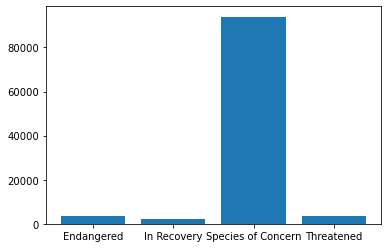

In [69]:
plt.bar(range(len(conservation_status_nonnan.conservation_status.value_counts())), conservation_status_nonnan.groupby('conservation_status').sum()['observations'])
ax = plt.subplot()
ax.set_xticks(range(len(conservation_status_nonnan.conservation_status.value_counts())))
ax.set_xticklabels(['Endangered', 'In Recovery', 'Species of Concern', 'Threatened'])
plt.show()
# of all the observations we can see that the majority are alocated to the species of concern

In [78]:
data = pd.concat([data, park_names_int], axis=1).reindex(data.index)
data = pd.concat([data, common_names_int], axis=1).reindex(data.index)
data = pd.concat([data, category_int], axis=1).reindex(data.index)

In [95]:
park_names_int = pd.get_dummies(data.park_name)
common_names_int = pd.get_dummies(data.common_names)
category_int = pd.get_dummies(data.category)
min_max_scaler = preprocessing.MinMaxScaler()
observations_scaled = min_max_scaler.fit_transform([data.observations])
data = data.drop(observations, 1)

KeyError: "['scientific_name' 'park_name'] not found in axis"

In [79]:
data = data.drop('scientific_name', 1)
data = data.drop('park_name', 1)
data = data.drop('category', 1)
data = data.drop('common_names', 1)

In [96]:
data.head()

,observations,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park,"A Bluegrass, Bluegrass","A Bramble, Black Raspberry","A Bramble, Blackberry","A Bramble, Highbush Blackberry","A Bramble, Truculent Blackberry",...,Zigzag Spiderwort,Zygodon Moss,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant,conservation_status
0,68,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
1,148,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,247,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,104,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,77,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


In [86]:
model = KMeans(n_clusters = 4)
model.fit(data)

KMeans(n_clusters=4)

In [87]:
labels = model.predict(data)
print(labels)

[3 2 0 ... 3 0 2]


In [90]:
data['conservation_status'] = labels

In [91]:
data.head()

,observations,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park,"A Bluegrass, Bluegrass","A Bramble, Black Raspberry","A Bramble, Blackberry","A Bramble, Highbush Blackberry","A Bramble, Truculent Blackberry",...,Zigzag Spiderwort,Zygodon Moss,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant,conservation_status
0,68,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
1,148,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,247,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,104,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,77,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


In [99]:
data.conservation_status.value_counts()

1    7308
0    6323
3    6233
2    5768
Name: conservation_status, dtype: int64